# AidSDK部署-摄像头单帧图像预测

同济子豪兄 

2023-8-19 9-1 9-2 9-4 9-16

## 导入工具包

In [1]:
import cv2
from cvs import *

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## AidLite初始化

In [2]:
import aidlite_gpu
aidlite = aidlite_gpu.aidlite()

[2023-09-16 17:43:01,980538][/tmp/ipykernel_10438/1811969939.py:2 <module>][DEBUG]:=======init


## 载入TFLite模型

In [3]:
model_path = 'mmseg2onnx_fastscnn_static_aimo_tflite/end2end_fp32.tflite'

In [4]:
# 文档：https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_4fast_annmodel

aidlite.FAST_ANNModel(
    model_path,           # 模型路径
    [1*1024*2048*3*4],    # 输入维度：Batch H W C 字节数
    [1*1024*2048*1*8],    # 输出维度：Batch H W C 字节数
    numberOfThreads=3,    # 加载数据和模型所需要的核数
    enableNNAPI=0         # 是否开启NNAPI
)

Result(id=1, result='load model ok!', error=None)

## 可视化配置

In [5]:
palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [6]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

## 初始化摄像头

In [41]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [42]:
cap = cvs.VideoCapture(Camera_ID)

('app runs on port:', 20934)
open the cam:0 ...


Exception in thread Thread-24989:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "cvs.py", line 184, in cvs.startcv
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 925, in start
    s = Server(main_gui_class, start=True, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 816, in __init__
    self.start()
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 834, in start
    self, self._certfile, self._keyfile, self._ssl_version, *self._userdata)
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 762, in __init__
    HTTPServer.__init__(self, server_address, RequestHandlerClass)
  File "/usr/lib/python3.7/socketserver.py", line 452, in __init__
    self.server_bind()
  File "/usr/lib/python3.7/http/aid_server.py", line 13

## 调用摄像头获取一帧画面

In [43]:
import time
time.sleep(3)
img_bgr = cap.read()

remi.server.ws   INFO     connection established: ('192.168.1.5', 60405)
remi.server.ws   INFO     handshake complete
remi.server.ws   ERROR    error parsing websocket
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 269, in on_message
    callback = get_method_by_name(runtimeInstances[widget_id], function_name)
  File "/usr/lib/python3.7/weakref.py", line 137, in __getitem__
    o = self.data[key]()
KeyError: '486239964856'


In [44]:
img_bgr.shape

(640, 480, 3)

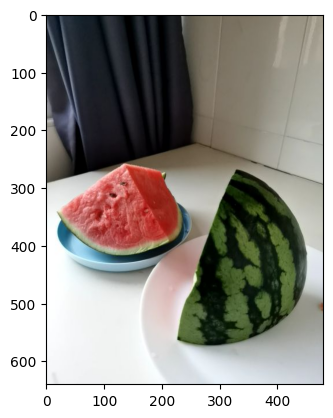

In [45]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 将手机拍摄到的竖屏图像旋转90度，变成横屏图像

In [46]:
img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_CLOCKWISE)

In [47]:
img_bgr.shape

(480, 640, 3)

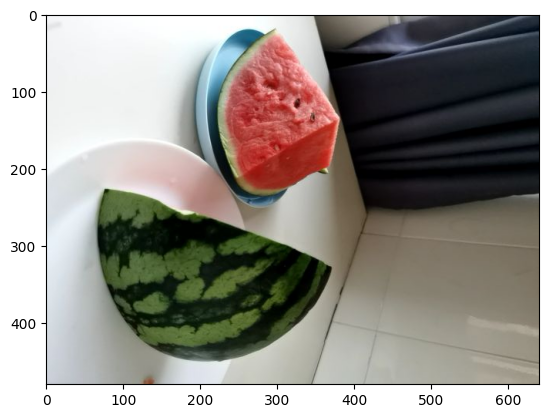

In [48]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 从原图中裁剪出高宽比1:2的最大图像

In [49]:
h, w = img_bgr.shape[0], img_bgr.shape[1]
new_h = w // 2 # 横屏图片，截取一半的宽度，作为新的高度
img_bgr_crop = img_bgr[0:new_h, :]

In [50]:
img_bgr_crop.shape

(320, 640, 3)

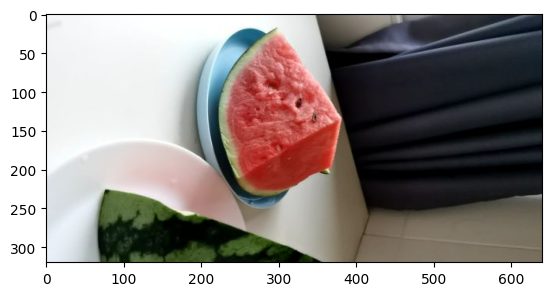

In [51]:
plt.imshow(img_bgr_crop[:,:,::-1])

## 缩放至模型要求的高1024 x 宽2048像素

In [52]:
img_bgr_resize = cv2.resize(img_bgr_crop, (2048, 1024)) # 缩放尺寸

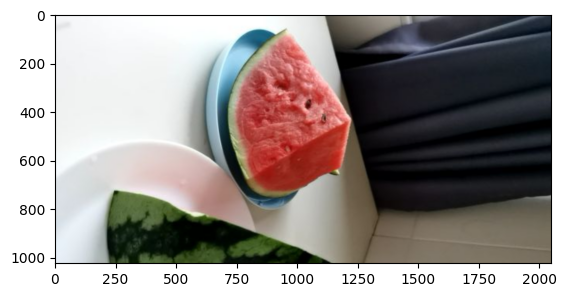

In [53]:
plt.imshow(img_bgr_resize[:,:,::-1])

## 预处理

In [54]:
# BGR 转 RGB
img_rgb_resize = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)

# 三通道的均值
mean = (0.485, 0.456, 0.406)

# 三通道的标准差
std = (0.229, 0.224, 0.225)

# 归一化
img_tensor = ((img_rgb_resize / 255) - mean) / std
img_tensor = img_tensor.astype('float32')

In [55]:
img_tensor.shape

(1024, 2048, 3)

## 推理预测

In [56]:
# 装填数据
# https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_5setinput_float32
aidlite.setInput_Float32(img_tensor)

Result(id=91, result=None, error=None)

In [57]:
# 推理预测
# https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_7invoke
aidlite.invoke() 

Result(id=91, result=None, error=None)

In [58]:
# 获得模型输出结果
output = aidlite.getOutput_Float32()

In [59]:
# 将模型输出结果转 bytes
output_bytes = output.tobytes()

In [60]:
# 再转 int64
pred_mask = np.frombuffer(output_bytes, dtype=np.int64).reshape(1024, 2048)

In [61]:
pred_mask.shape

(1024, 2048)

## 将预测的整数ID，映射为对应类别的颜色

In [62]:
opacity = 0.3 # 透明度，越大越接近原图

pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)

In [63]:
pred_viz.shape

(1024, 2048, 3)

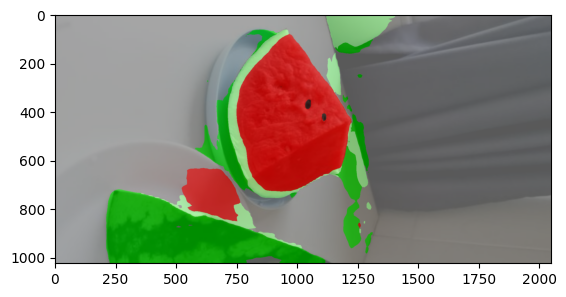

In [64]:
plt.imshow(pred_viz[:,:,::-1])
plt.show()

## 后处理，便于在手机屏幕上显示

In [65]:
img_bgr = pred_viz

In [66]:
img_bgr = cv2.resize(img_bgr, (640, 320)) # 缩放尺寸

In [67]:
img_bgr.shape

(320, 640, 3)

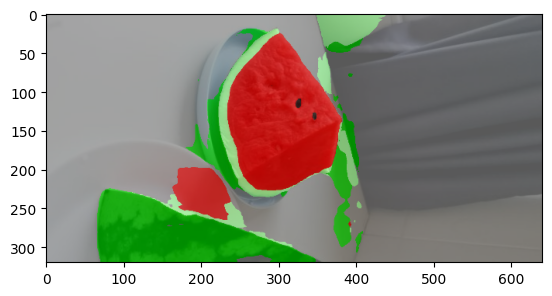

In [68]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [69]:
img_bgr = cv2.rotate(img_bgr, cv2.ROTATE_90_COUNTERCLOCKWISE)

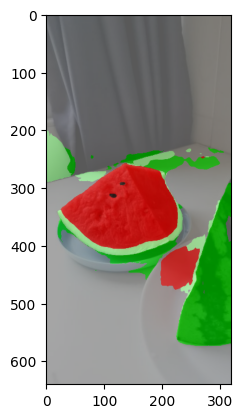

In [70]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 在手机屏幕上显示

In [71]:
cvs.imshow(img_bgr)

remi.server.ws   ERROR    Error managing incoming websocket message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 175, in read_next_message
    self.on_message(from_websocket(decoded))
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 245, in on_message
    self.send_message(_MSG_ACK)
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 209, in send_message
    self.request.sendall(out)
BrokenPipeError: [Errno 32] Broken pipe
remi.request     ERROR    sending websocket spontaneous message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 497, in _send_spontaneous_websocket_message
    if ws.send_message(message):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 209, in send_message
    self.request.sendall(out)
BrokenPipeError: [Errno 32] Broken pipe
